# Прогнозирование количества заказов такси на следующий час

# Этапы проекта

[1. Загрузка и ресемплирование данных по одному часу.](#step1)

[2. Анализ данных.](#step2)

[3. Обучение моделей](#step3)

[4. Тестирование моделей и вывод.](#step4)


# Шаг 1. Подготовка <a id='step1'></a>

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

Загрузка и просмотр данных:

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi = taxi.sort_index()
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Имеем данные по заказам с 1 марта 2018 по 31 августа 2018. Жаль что нет данных за пару лет, или хотя бы за один полный год. Ведь есть сезонность пассажиропотока в течение года, связанная с периодами отпусков или, например, каникул. 

Ресемплирование временного ряда с интервалом 1 час:

In [4]:
taxi = taxi.resample('1H').sum()
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


# Шаг 2. Анализ <a id='step2'></a>

Для лучшего понимания временного ряда рассмотрим тренды и сезонность:

In [5]:
def decompose_data(data):
    decomposed = seasonal_decompose(data) 
    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

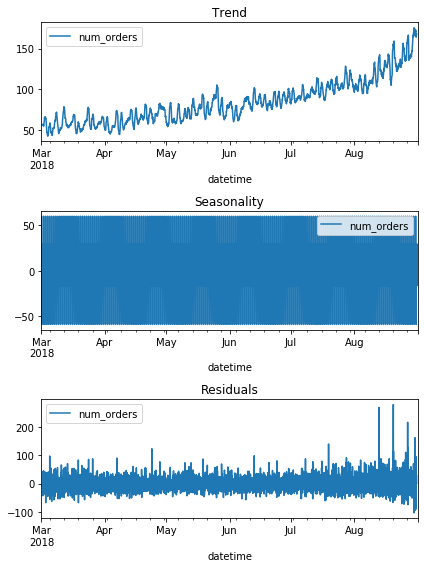

In [6]:
#сначала посмотрим на всех данных
decompose_data(taxi)

Заметен тренд на рост заказов, особенно в конце лета. Сезонность нужно рассматривать на более коротком промежутке. Попробуем посмотреть на срезах одного месяца, недели, и одного дня:

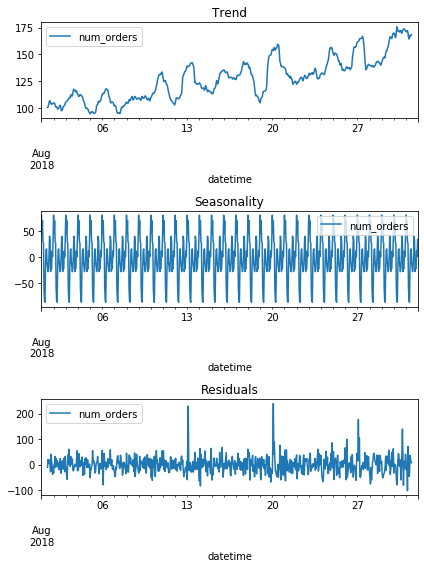

In [7]:
decompose_data(taxi['2018-08-01':'2018-08-31'])

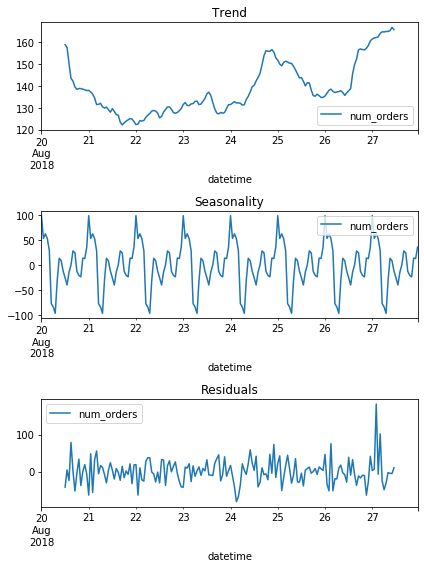

In [8]:
decompose_data(taxi['2018-08-20':'2018-08-27'])

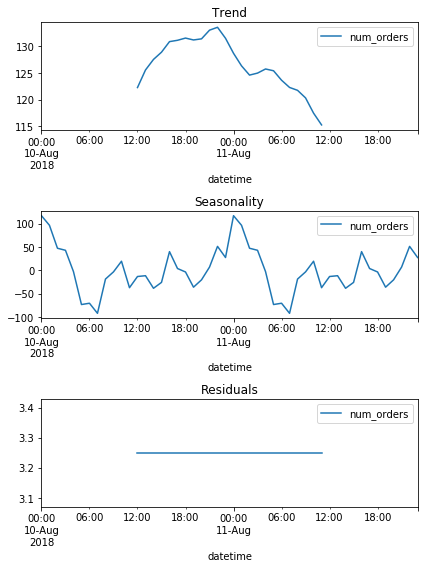

In [9]:
decompose_data(taxi['2018-08-10':'2018-08-11'])

На срезе в один месяц прослеживается только тренд роста заказов к концу месяца, сезонность также не видна.

На срезе в одну неделю заметно, что количество заказов максимально по пятницам и понедельникам, в середине недели минимально, а для сезонности интервал нужен снова еще меньше.

На срезе в два дня видно, что максимальное число заказов бывает по ночам: наверное, днем часть людей предпочитает добираться общественным транспортом, который, к сожалению ездит не круглосуточно.

# Шаг 3. Обучение <a id='step3'></a>

Перед обучение создадим признаки и поделим данные.

При анализе данных мы заметили, что количество заказов зависит от месяца, дня недели и времени суток. Создадим соответствующие календарные признаки и отстающие значения:

In [10]:
#функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(taxi, 6, 4)
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,86.5


Перед обучением разделим данные на обучающую и тестовую выборки, выделим признаки и целевой признак:

In [12]:
#поделим на обучающую и тестовуюи проверим, что деление корректно
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 06:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [13]:
#выделим feture и test
feature_train = train.drop('num_orders', axis =1)
target_train = train['num_orders']
feature_test = test.drop('num_orders', axis =1)
target_test = test['num_orders']

Обучим несколько моделей.

Начнем с простейшей линейной регрессии:

In [14]:
model = LinearRegression()
model.fit(feature_train,target_train)
predict_LR_train = model.predict(feature_train)
predict_LR = model.predict(feature_test)

Попробуем случайный лес:

In [15]:
estimator = RandomForestRegressor(random_state=123)

param_grid = {
    'n_estimators': [40,50,60,70]
}
tscv = TimeSeriesSplit(n_splits=2)
model = GridSearchCV(estimator, param_grid, cv=tscv,)
model.fit(feature_train, target_train)
model.best_params_

{'n_estimators': 70}

In [16]:
model = RandomForestRegressor(random_state=123,n_estimators=70)
model.fit(feature_train,target_train)
predict_RFR_train = model.predict(feature_train)
predict_RFR = model.predict(feature_test)

И напоследок, градиентный бустинг:

In [17]:
estimator = LGBMRegressor()

param_grid = {
    
    'max_depth': [20,30,40],
    'num_leaves': [30,40,50]
}
tscv = TimeSeriesSplit(n_splits=2)
modellgb = GridSearchCV(estimator, param_grid, cv=tscv)
modellgb.fit(feature_train, target_train)
modellgb.best_params_

{'max_depth': 30, 'num_leaves': 40}

In [18]:
modellgb = LGBMRegressor(num_leaves=50,max_depth=20)
modellgb.fit(feature_train, target_train)
predict_LGBMR_train = model.predict(feature_train)
predict_LGBMR = modellgb.predict(feature_test)

In [19]:
result_train = pd.DataFrame({
    'model': [
        'LinearRegression', 
        'RandomForestRegressor', 
        'LGBMRegressor'], 
    'RMSE': [
        mean_squared_error(target_train, predict_LR_train)**0.5, 
        mean_squared_error(target_train, predict_RFR_train)**0.5, 
        mean_squared_error(target_train, predict_LGBMR_train)**0.5
    ]
})

In [20]:
result_train

,model,RMSE
0,LinearRegression,30.470521
1,RandomForestRegressor,8.596058
2,LGBMRegressor,8.596058


# Шаг 4. Тестирование <a id='step4'></a>

Протестируем модели и сравним метрики (целевое значение метрики RMSE должно быть не более 48):

In [21]:
result = pd.DataFrame({
    'model': [
        'LinearRegression', 
        'RandomForestRegressor', 
        'LGBMRegressor'], 
    'RMSE': [
        mean_squared_error(target_test, predict_LR)**0.5, 
        mean_squared_error(target_test, predict_RFR)**0.5, 
        mean_squared_error(target_test, predict_LGBMR)**0.5
    ]
})

In [22]:
result

,model,RMSE
0,LinearRegression,53.051434
1,RandomForestRegressor,45.752410
2,LGBMRegressor,43.947545


Лучшая метрика у модели градиентного бустинга. В этой работе не потребовалось сложного и долгого подбора параметров для достижения целевой метрики, подбор параметров и обучение моделей не занимало очень много времени, поэтому мы не включили в оценку моделей такие показатели как время обучения и скорость предсказания, которые тоже играют важную роль при выборе оптимальной модели.